Copyright 2021 Lawrence Livermore National Security, LLC and other MuyGPyS
Project Developers. See the top-level COPYRIGHT file for details.

SPDX-License-Identifier: MIT

# Univariate Regression Tutorial

This notebook walks through a simple regression workflow and explains the componenets of `MuyGPyS`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from MuyGPyS.testing.gp import benchmark_sample, benchmark_sample_full, BenchmarkGP

We will set a random seed here for consistency when building docs.
In practice we would not fix a seed.

In [2]:
np.random.seed(0)

## Sampling a Curve from a Conventional GP

This notebook will use a simple one-dimensional curve sampled from a conventional Gaussian process.
The Gaussian process in question is implemented in `MuyGPyS.testing.gp.BenchmarkGP`. 
It is intended for testing purposes only. 
We will specify the domain as a grid on a one-dimensional surface and divide the observations into train and test data.
Feel free to experiment with different parameters.

In [3]:
lb = -10.0
ub = 10.0
data_count = 10001
train_step = 10
x = np.linspace(lb, ub, data_count).reshape(data_count, 1)
test_features = x[np.mod(np.arange(data_count), train_step) != 0, :]
train_features = x[::train_step, :]
test_count, _ = test_features.shape
train_count, _ = train_features.shape

We will now define a Matern kernel function and create a conventional GP.
Note here that we are setting a small value for `eps`, the prior variance of the "nugget" or diagonal noise matrix added to the raw kernel matrix to a small value purely for numerical stability.
This is an idealized experiment with no instrument error.

In [4]:
nugget_var = 1e-14
fixed_length_scale = 1.0
benchmark_kwargs = {
    "kern": "matern",
    "metric": "l2",
    "eps": {"val": nugget_var},
    "nu": {"val": 2.0},
    "length_scale": {"val": fixed_length_scale},
}
gp = BenchmarkGP(**benchmark_kwargs)

Finally, we will sample a curve from this GP prior and visualize it.
Note that we perturb the train responses (the values that our model will actual receive) with Gaussian measurement noise.
Further note that this is not especially fast, as sampling from a conventional Gaussian process requires computing the Cholesky decomposition of a `(data_count, data_count)` matrix.

In [5]:
y = benchmark_sample(gp, x)

In [6]:
test_responses = y[np.mod(np.arange(data_count), train_step) != 0, :]
measurement_eps = 1e-5
train_responses = y[::train_step, :] + np.random.normal(0, measurement_eps, size=(train_count,1))

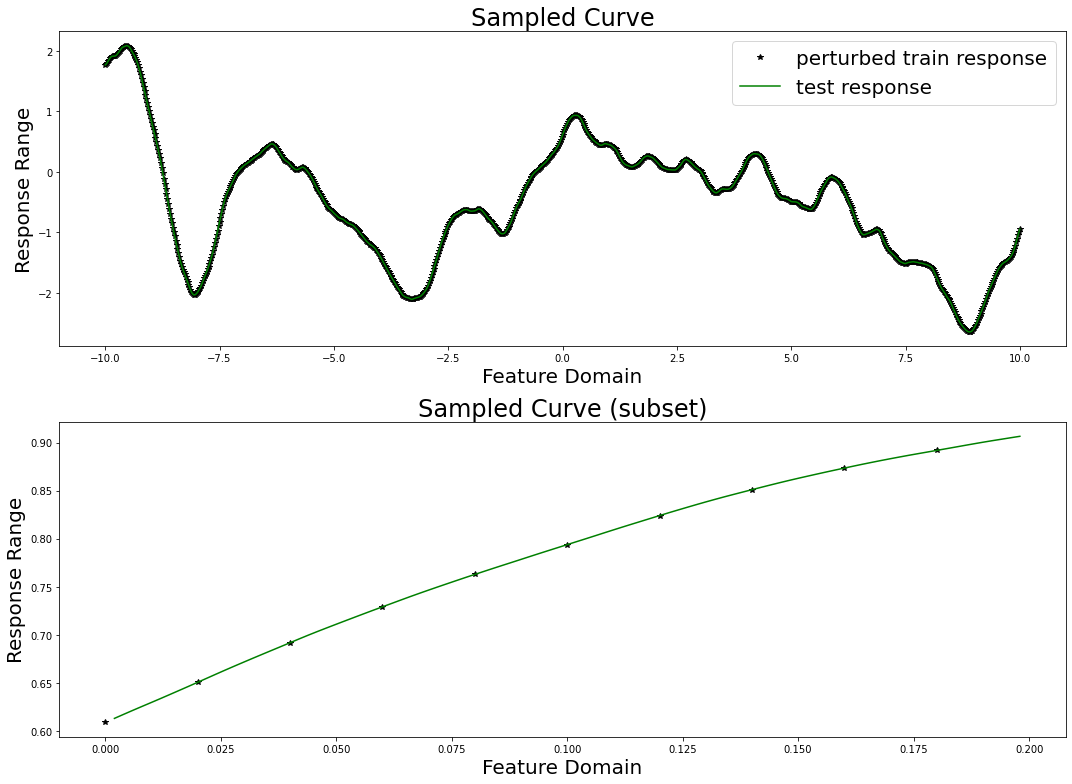

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(15, 11))

axes[0].set_title("Sampled Curve", fontsize=24)
axes[0].set_xlabel("Feature Domain", fontsize=20)
axes[0].set_ylabel("Response Range", fontsize=20)
axes[0].plot(train_features, train_responses, "k*", label="perturbed train response")
axes[0].plot(test_features, test_responses, "g-", label="test response")
axes[0].legend(fontsize=20) 

vis_subset_size = 10
mid = int(train_count / 2)

axes[1].set_title("Sampled Curve (subset)", fontsize=24)
axes[1].set_xlabel("Feature Domain", fontsize=20)
axes[1].set_ylabel("Response Range", fontsize=20)
axes[1].plot(
    train_features[mid:mid + vis_subset_size], 
    train_responses[mid:mid + vis_subset_size], 
    "k*", label="perturbed train response"
)
axes[1].plot(
    test_features[mid * (train_step - 1):mid * (train_step - 1) + (vis_subset_size * (train_step - 1))], 
    test_responses[mid * (train_step - 1):mid * (train_step - 1) + (vis_subset_size * (train_step - 1))], 
    "g-", label="test response"
)

plt.tight_layout()

plt.show()

We will now attempt to recover the response on the held-out test data by training a univariate `MuyGPS` model on the perturbed training data.

## Constructing Nearest Neighbor Lookups

[NN_Wrapper](../MuyGPyS/neighbors.rst) 
is an api for tasking several KNN libraries with the construction of lookup indexes that empower fast training and inference. 
The wrapper constructor expects the training features, the number of nearest neighbors, and a method string specifying which algorithm to use, as well as any additional kwargs used by the methods. 
Currently supported implementations include 
[exact KNN using sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) ("exact") and 
[approximate KNN using hnsw](https://github.com/nmslib/hnswlib) ("hnsw").

Here we construct an exact KNN data example with k = 30

In [8]:
from MuyGPyS.neighbors import NN_Wrapper
nn_count = 30
nbrs_lookup = NN_Wrapper(train_features, nn_count, nn_method="exact", algorithm="ball_tree")

This `nbrs_lookup` index is then usable to find the nearest neighbors of queries in the training data.

## Sampling Batches of Data

`MuyGPyS` includes convenience functions for sampling batches of data from existing datasets.
These batches are returned in the form of row indices, both of the sampled data as well as their nearest neighbors.

Here we sample a random batch of `train_count` elements. 
This results in using *all* of the train data for training. 
We only do that in this case because this example uses a relatively small amount of data.
In practice, we would instead set `batch_count` to a resaonable number.
In practice we find reasonable values to be in the range of 500-2000.

In [9]:
from MuyGPyS.optimize.batch import sample_batch
batch_count = train_count
batch_indices, batch_nn_indices = sample_batch(
    nbrs_lookup, batch_count, train_count
)

These `indices` and `nn_indices` arrays are the basic operating blocks of `MuyGPyS` linear algebraic inference.
The elements of `indices.shape == (batch_count,)` lists all of the row indices into `train_features` and `train_responses` corresponding to the sampled data.
The rows of `nn_indices.shape == (batch_count, nn_count)` list the row indices into `train_features` and `train_responses` corresponding to the nearest neighbors of the sampled data.

While the user need not use the 
[MuyGPyS.optimize.batch](../MuyGPyS/optimize/batch.rst) 
sampling tools to construct these data, they will need to construct similar indices into their data in order to use `MuyGPyS`.

## Setting and Optimizing Hyperparameters

One initializes a 
[MuyGPS](../MuyGPyS/gp/MuyGPS.rst)
object by indicating the kernel, as well as optionally specifying hyperparameters.

Consider the following example, which constructs a Matern kernel with all parameters fixed aside from `"nu"` and `"sigma_sq"`.
Note that we are here making the simplifying assumtions that we know the true `length_scale` and `measurement error`. 

In [10]:
from MuyGPyS.gp.muygps import MuyGPS
k_kwargs = {
    "kern": "matern",
    "metric": "l2",
    "eps": {"val": measurement_eps},
    "nu": {"val": "log_sample", "bounds": (0.1, 5.0)},
    "length_scale": {"val": fixed_length_scale},
}
muygps = MuyGPS(**k_kwargs)

Hyperparameters can be initialized or reset using dictionary arguments containing the optional `"val"` and `"bounds"` keys.
`"val"` sets the hyperparameter to the given value, and `"bounds"` determines the upper and lower bounds to be used for optimization.
If `"bounds"` is set, `"val"` can also take the arguments `"sample"` and `"log_sample"` to generate a uniform or log uniform sample, respectively.
If `"bounds"` is set to `"fixed"`, the hyperparameter will remain fixed during any optimization.
This is the default behavior for all hyperparameters if `"bounds"` is unset by the user.

One sets the model hyperparameter `eps`, as well as kernel-specific hyperparameters, e.g. `nu` and  `length_scale` for the Matern kernel, at initialization as above.

There is one common hyperparameter, the `sigma_sq` scale parameter, that violates these rules.
`sigma_sq` cannot be directly set by the user, and always initializes to the value `"unlearned"`. 
We will show how to train `sigma_sq` below.
All hyperparameters other than `sigma_sq` are assumed to be fixed unless otherwise specified.

MuyGPyS depends upon linear operations on specially-constructed tensors in order to efficiently estimate GP realizations.
Constructing these tensors depends upon the nearest neighbor index matrices that we described above.
We can construct a distance tensor coalescing all of the square pairwise distance matrices of the nearest neighbors of a batch of points.

This snippet constructs a matrix of shape `(batch_count, nn_count)` coalescing all of the distance vectors between the same batch of points and their nearest neighbors.

In [11]:
from MuyGPyS.gp.distance import crosswise_distances
crosswise_dists = crosswise_distances(
    train_features, 
    train_features, 
    batch_indices,
    batch_nn_indices,
    metric="l2",
)

We can similarly construct a Euclidean distance tensor of shape `(batch_count, nn_count, nn_count)` containing the pairwise distances of the nearest neighbor sets of each sampled batch element.

In [12]:
from MuyGPyS.gp.distance import pairwise_distances
pairwise_dists = pairwise_distances(
    train_features, batch_nn_indices, metric="l2"
)

The `MuyGPS` object we created earlier allows us to easily realize kernel tensors by way of its kernel function.

In [13]:
Kcross = muygps.kernel(crosswise_dists)
K = muygps.kernel(pairwise_dists)

In order to perform Gaussian process regression, we must utilize these kernel tensors in conjunction with their associated known responses.
We can construct these matrices using the index matrices we derived earlier.

In [14]:
batch_targets = train_responses[batch_indices, :]
batch_nn_targets = train_responses[batch_nn_indices, :]

Since we often must realize `batch_targets` and `batch_nn_targets` in close proximity to `crosswise_dists` and `pairwise_dists`, the library includes a convenience function 
[make_train_tensors()](../MuyGPyS/gp/distance.rst)
that bundles these operations.

In [15]:
from MuyGPyS.gp.distance import make_train_tensors
(
    crosswise_dists,
    pairwise_dists,
    batch_targets,
    nn_targets,
) = make_train_tensors(
    muygps.kernel.metric,
    batch_indices,
    batch_nn_indices,
    train_features,
    train_responses,
)

We supply a convenient leave-one-out cross-validation utility that utilizes the `crosswise_dists` and `pairwise_dists` tensors to repeatedly realize kernel tensors during optimization.

In [16]:
from MuyGPyS.optimize.chassis import scipy_optimize_from_tensors
muygps = scipy_optimize_from_tensors(
    muygps,
    batch_targets,
    batch_nn_targets,
    crosswise_dists,
    pairwise_dists,
    loss_method="mse",
    verbose=True,
)

parameters to be optimized: ['nu']
bounds: [[0.1 5. ]]
initial x0: [2.28105771]
optimizer results: 
      fun: 3.6995442385991543e-06
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.2835038e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
   status: 0
  success: True
        x: array([2.28105771])


Note here that the returned value for `nu` might be different from the `nu` used by the conventional GP.

If you do not need to retain the distances tensors or batch targets for future reference, you can use a related function that realizes them internally.

In [17]:
# from MuyGPyS.optimize.chassis import scipy_optimize_from_indices
# muygps = scipy_optimize_from_indices(
#     muygps,
#     batch_indices,
#     batch_nn_indices,
#     train_features,
#     train_responses,
#     loss_method="mse",
#     verbose=False,
# )

As it is a variance scaling parameter that is insensitive to prediction-based optimization, we separately optimize `sigma_sq`.
In this case, we invoke 
[MuyGPS.sigma_sq_optim()](../MuyGPyS/gp/MuyGPS.rst), 
which approximates `sigma_sq` based upon the mean of the closed-form `sigma_sq` solutions associated with each of its batched nearest neighbor sets.
Note that this method is sensitive to several factors, include `batch_count`, `nn_count`, and the overall size of the dataset, tending to perform better as each of these factors increases. 

This is usually performed after optimizing other hyperparameters.

In [18]:
K = muygps.kernel(pairwise_dists)
muygps.sigma_sq_optim(K, batch_nn_indices, train_responses)

array([0.63772588])

## Inference

With set (or learned) hyperparameters, we are able to use the `muygps` object to predict the response of test data.
Several workflows are supported.

See below a simple regression workflow, using the data structures built up in this example.
This workflow uses the compact tensor-making function 
[make_regress_tensors()](../MuyGPyS/gp/distance.rst)
to succinctly create tensors defining the `pairwise_dists` among each nearest neighbor set, the `crosswise_dists` between each test point and its nearest neighbor set, and the `nn_targets` or responses of the nearest neighbors in each set.
We then create the `Kcross` cross-covariance matrix and `K` covariance tensor and pass them to [MuyGPS.regress()](../MuyGPyS/gp/MuyGPS.rst) in order to obtain our predictions.

In [19]:
from MuyGPyS.gp.distance import make_regress_tensors

# make the indices
test_count, _ = test_features.shape
indices = np.arange(test_count)
nn_indices, _ = nbrs_lookup.get_nns(test_features)

# make distance and target tensors
(
    crosswise_dists,
    pairwise_dists,
    nn_targets,
) = make_regress_tensors(
    muygps.kernel.metric,
    indices,
    nn_indices,
    test_features,
    train_features,
    train_responses,
)

# Make the kernels
Kcross = muygps.kernel(crosswise_dists)
K = muygps.kernel(pairwise_dists)

# perform Gaussian process regression 
predictions, variances = muygps.regress(
    K,
    Kcross,
    train_responses[nn_indices, :],
    variance_mode="diagonal",
    apply_sigma_sq=True,
)

We here evaluate our prediction performance in terms of RMSE, mean diagonal posterior variance, the mean 95% confidence interval size, and the coverage, which ideally should be near 95%. 

In [20]:
from MuyGPyS.optimize.objective import mse_fn

confidence_intervals = np.sqrt(variances) * 1.96
coverage = (
    np.count_nonzero(
        np.abs(test_responses - predictions)
        < confidence_intervals.reshape(test_count, 1)
    )
    / test_count
)
print(f"RMSE: {np.sqrt(mse_fn(predictions, test_responses))}")
print(f"mean diagonal variance: {np.mean(variances)}")
print(f"mean confidence interval size: {np.mean(confidence_intervals * 2)}")
print(f"coverage: {coverage}")

RMSE: 0.0013556922765552452
mean diagonal variance: 1.7126200137785838e-06
mean confidence interval size: 0.0051293830274501614
coverage: 0.9381111111111111


Again, if you do not need to reuse your tensors, you can run the more compact workflow:

In [21]:
# # make the indices
# test_count, _ = test_features.shape
# indices = np.arange(test_count)
# nn_indices, _ = nbrs_lookup.get_nns(test_features)

# predictions, variance = muygps.regress_from_indices(
#     indices, 
#     nn_indices,
#     test_features,
#     train_features,
#     train_responses,
#     variance_mode="diagonal",
#     apply_sigma_sq=True,
# )

These regression examples return predictions (posterior means) and variances for each element of the test dataset.
These variances are in the form of diagonal and independent variances that encode the uncertaintainty of the model's predictions at each test point.
To scale the predictions, they should be multiplied by the trained `sigma_sq` scaling parameters, of which there will be one scalar associated with each dimension of the response.
The kwarg `apply_sigma_sq=True` indicates that this scaling will be performed automatically.
This is the default behavior, but will be skipped if `sigma_sq == "unlearned"`.

For a univariate resonse whose variance is obtained with `apply_sigma_sq=False`, the scaled predicted variance is equivalent to multiplying the predicted variances by `muygps.sigma_sq()`.

In [22]:
# predictions, variances = muygps.regress_from_indices(
#     indices, 
#     nn_indices,
#     test_features,
#     train_features,
#     train_responses,
#     variance_mode="diagonal",
#     apply_sigma_sq=False,
# )
# scaled_variance = muygps.sigma_sq() * variances

We can also plot our responses and evaluate their performance. 
We plot below the predicted and true curves, as well as the 95% confidence interval.
We plot a smaller subset of the data in the lower curve in order to better scrutinize the 95% confidence interval.

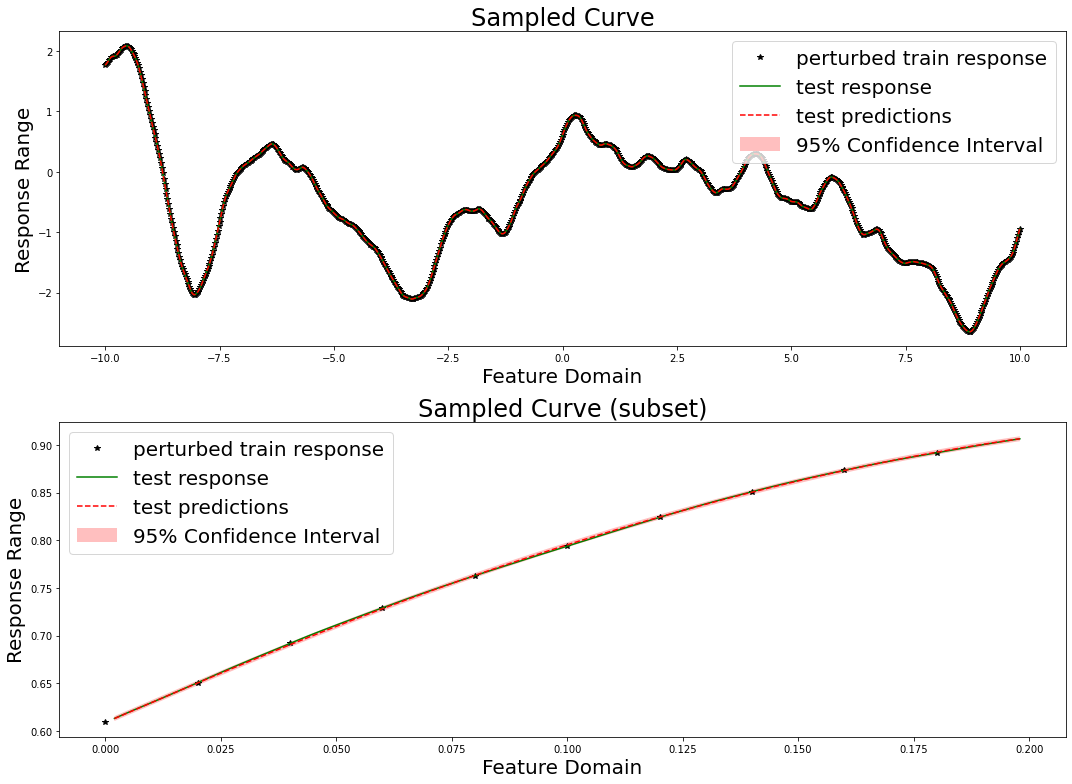

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(15, 11))

axes[0].set_title("Sampled Curve", fontsize=24)
axes[0].set_xlabel("Feature Domain", fontsize=20)
axes[0].set_ylabel("Response Range", fontsize=20)
axes[0].plot(train_features, train_responses, "k*", label="perturbed train response")
axes[0].plot(test_features, test_responses, "g-", label="test response")
axes[0].plot(test_features, predictions, "r--", label="test predictions")
axes[0].fill_between(
    test_features[:, 0], 
    (predictions[:, 0] - confidence_intervals),
    (predictions[:, 0] + confidence_intervals),
    facecolor="red",
    alpha=0.25,
    label="95% Confidence Interval",
)
axes[0].legend(fontsize=20)

axes[1].set_title("Sampled Curve (subset)", fontsize=24)
axes[1].set_xlabel("Feature Domain", fontsize=20)
axes[1].set_ylabel("Response Range", fontsize=20)
axes[1].plot(
    train_features[mid:mid + vis_subset_size], 
    train_responses[mid:mid + vis_subset_size], 
    "k*", label="perturbed train response"
)
axes[1].plot(
    test_features[mid * (train_step - 1):mid * (train_step - 1) + (vis_subset_size * (train_step - 1))], 
    test_responses[mid * (train_step - 1):mid * (train_step - 1) + (vis_subset_size * (train_step - 1))], 
    "g-", label="test response"
)
axes[1].plot(
    test_features[mid * (train_step - 1):mid * (train_step - 1) + (vis_subset_size * (train_step - 1))], 
    predictions[mid * (train_step - 1):mid * (train_step - 1) + (vis_subset_size * (train_step - 1))],
    "r--", label="test predictions")
axes[1].fill_between(
    test_features[mid * (train_step - 1):mid * (train_step - 1) + (vis_subset_size * (train_step - 1))][:, 0], 
    (predictions[:, 0] - confidence_intervals)[mid * (train_step - 1):mid * (train_step - 1) + (vis_subset_size * (train_step - 1))],
    (predictions[:, 0] + confidence_intervals)[mid * (train_step - 1):mid * (train_step - 1) + (vis_subset_size * (train_step - 1))],
    facecolor="red",
    alpha=0.25,
    label="95% Confidence Interval",
)
axes[1].legend(fontsize=20)

plt.tight_layout()

plt.show()